## Ejemplo de análisis de datos: visualizaciones y análisis de sentimiento.

Se van a utilizar datos obtenidos de la aplicación de GoodReads, donde se suben reviews sobre los libros leidos y se mantienen listas de libros leidos y por leer, y también datos de Booking sobre reviews recogidas en los distintos hoteles anunciados en la aplicación, y sobre estas reviews realizar un análisis de sentimiento.

#### Obtención de datos.

Algunas de las mejores webs para conseguir datos para realizar análisis son las siguientes:
- https://datahub.io : web general con los datos almacenados en distintas categorías y de cualquier parte del mundo.
- https://www.kaggle.com/datasets : web donde se realizan retos de programación y análisis con los datos que se indica en dicho reto. En el apartado de datasets hay multitud de datos de distinta temática.
- https://www.data.gov : los datos subidos por el gobierno de EEUU.
- https://datasetsearch.research.google.com : buscador de datos de Google.
- https://datos.gob.es/es : web con los datos subidos por el gobierno de España.
- https://datos.madrid.es/portal/site/egob : datos subidos por el ayuntamiento de Madrid.
- https://www.ine.es : página del instituto nacional de estadística de España. Sobre cualquier temática de la que obtienen información, se pueden realizar búsquedas y descargar datos.
- https://www.europeandataportal.eu/en : portal con los datos subidos por la Unión Europea.

Como se puede ver en cualquiera de estas webs, hay datos sobre cualquier temática, y en multitud de formatos como podrían ser excel, csv o json.

Además en el caso de España, también multitud de comunidades autónomas tienen su propio portal donde suben datos exclusivos de su región.

También indicar que además de poder descargar los datos en el formato que queramos desde las propias páginas indicadas, la mayoría también disponen de una API para poder consumir datos desde distintos lenguajes y aplicaciones.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# imports necesarios
# no mostrar warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

import re
import string
import unicodedata
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

# !pip install textblob (en caso de no tenerlo instalado previamente)
from textblob import TextBlob

import spacy
from spacy import displacy

from collections import Counter

import sklearn as skl
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josemanuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# funciones 

# función para cargar los datos en un dataframe y ver el tamaño y sus columnas/atributos
def cargar_datos(data):
    df = pd.read_csv('./'+data, sep=',')
    print("Dataset: num_rows: %d\tColumnas: %d\n" % (df.shape[0], df.shape[1]))
    print("columns:\n", list(df.columns))
    
    return df


# función para visualizar estadísticas esenciales de los datos, información sobre cada columna y si hay nulos
def visualizar_datos(df):
    print("Estadísticas esenciales de los datos:")
    print(df.describe().T)
    print('\n')
    print("Información sobre cada atributo de los datos:")
    print(df.info())
    print('\n')
    print("Ver si hay datos nulos (False indica que ese atributo tiene registros vacíos o nulos):")
    print(df.notnull().all())


# al df se le eliminan las columnas que indiquemos y si tiene nulos o vacíos los rellenamos según corresponda,
# con la media si son datos numéricos, y la moda si son datos categóricos.
def preparar_df(df,nulos,columnas,tipo):
    # eliminar información que no vamos a necesitar o no nos resulta relevante para el trabajo posterior
    df_result = df.drop(columns=columnas, axis=1)
    # según el tipo de dataframe en el atributo de páginas quitamos el "pages"
    if tipo == 1:
        df_result['book_pages'] = df_result['book_pages'].str.slice(0,-6)
        df_result['book_pages'] = df_result['book_pages'].apply(pd.to_numeric)
    
    # partimos los atributos entre categóricos y numéricos para rellenar los datos que haya vacíos según el caso.
    # Agrupando columnas por tipo de datos
    tipos = df_result.columns.to_series().groupby(df_result.dtypes).groups
    # Lista de columnas categóricas
    ctext = tipos[np.dtype('object')]
    # Lista de columnas numéricas
    columnas = df_result.columns 
    cnum = list(set(columnas) - set(ctext))

    # Completando valores faltantes de datos cuantitativos
    for c in cnum:
        mean = df_result[c].mean()
        df_result[c] = df_result[c].fillna(mean)
    
    # Completando valores faltantes de datos categóricos
    for c in ctext:
        mode = df_result[c].mode()[0]
        df_result[c] = df_result[c].fillna(mode)
    
    # convertimos a numérico el dato
    if tipo == 1:
        df_result["book_pages"] = df_result["book_pages"].astype(int)
    
    return df_result
    

# función que muestra un gráfico con los datos agrupados por un atributo, además también se muestran los datos
# de dicho atributo por un rango o segmentación de los valores.
def grafico_segmentacion(df, atributo, rango, titulo, label_x, label_y):
    # con el atributo y el rango de valores se hace la segmentación
    segmento = pd.cut(df[atributo], rango)
    # se muestra por pantalla los valores por cada valor del rango
    print(pd.value_counts(segmento))

    # Creando el grafico de barras desde pandas
    plot = pd.value_counts(segmento).plot(kind='bar', title=titulo)
    plot.set_ylabel(label_y)
    plot.set_xlabel(label_x)
    
    plt.show()
    

# función para mostrar la nube de palabras de un texto, para ver resaltadas las palabras más comunes o importantes
# pasamos la lista de stopwords para no tener en cuenta ciertas palabras muy comunes en el lenguaje
def show_wordcloud(data, stopwords, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        stopwords = stopwords,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
     

# funciones de preprocesado y limpieza de los textos. Se eliminan caracteres y palabras que no tienen importancia
# o que pueden confundir al aprendizaje y análisis de los textos.
def limpiar_texto(texto):
    # quitamos RT, @nombre_usuario, links y urls, hashtags, menciones, caracteres extraños o emoticonos
    texto = re.sub('  +', ' ', texto)
    # eliminar acentos
    texto = ''.join((c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'))  
    # convertir la repetición de una letra más de 2 veces a 1
    # biennnnn --> bien
    texto = re.sub(r'(.)\1+', r'\1\1', texto)
    # eliminar "RT", "@usuario", o los enlaces que es información que no sería útil analizar
    texto = re.sub(r'^RT[\s]+', '', texto)
    texto = re.sub('','',texto).lower() 
    texto = re.sub(r'http\S+', '', texto) 
    texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto)
    texto = re.sub(r'#', '', texto)
    texto = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", texto)
    texto = re.sub(r'[0-9]', '', texto) 

    return texto


# Función que le pasamos un Dataframe y nos lo devuelve con los datos preprocesados con la función anterior
def limpiar_df(df):
    df_clean = df.copy()
    df_clean['review'] = df_clean['review'].apply(limpiar_texto)
    
    return df_clean


# Función que genera los conjuntos de train y test a partir de un dataframe. Reparto 90% train - 10% test
def split_df(df):
    X_eng = df['review']
    y_eng = df['Reviewer_Score']

    X, X_test, y, y_test = train_test_split(X_eng, y_eng, test_size=0.1, random_state=42)

    return X, X_test, y, y_test


# Función que genera el pipeline y parámetros del modelo, y lo entrena.
# Se centra la prueba en ver el resultado con distintos clasificadores para ver que tipo de algoritmo da los 
# mejores resultados. En cuanto al vectorizador se prueba tanto con CountVectorizer como con TDIDFVectorizer.
# No se definen muchos otros parámetros por cuestión de tiempo y del elevado coste computacional en el caso de
# jugar con muchos parámetros y varias posibilidades para cada uno.
def generar_modelo(clasificador, stopwords, X_train, y_train):
    # uso de tokenizer que es una buena práctica en el tratamiento de textos
    tokenizer = TweetTokenizer().tokenize

    pipeline = Pipeline([
        ('vectorizer', None),
        ('classifier', clasificador)]
    )
    
    # también se prueba a usar o no stopwords, que serían palabras muy comunes en el lenguaje, que no tienen valor
    # real a la hora de analizar el sentimiento de un texto y pueden no tenerse en cuenta.
    params = {
        'vectorizer': [CountVectorizer(binary=True,tokenizer=tokenizer),\
                       CountVectorizer(binary=False,tokenizer=tokenizer),\
                       TfidfVectorizer(use_idf=False, tokenizer=tokenizer),\
                       TfidfVectorizer(use_idf=True, tokenizer=tokenizer)],
        'vectorizer__stop_words': [None, stopwords],
    }

    # uso también de StratifiedKFold que es otra buena práctica
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    modelo = GridSearchCV(pipeline, params, n_jobs=-1, cv=skf, refit='f1_weighted')
    modelo.fit(X_train, y_train)

    return modelo


# Función que evalua el modelo que le pasamos y saca las métricas que se quieren observar
def evaluar_modelos(modelo1, x_eng_test, y_eng_test):
    # pintamos los mejores parámetros de cada modelo
    print("Mejores parámetros del modelo para datos en inglés: \n", modelo1.best_params_)

    # se usan los modelos entrenados para predecir los datos de test
    y_pred_eng = modelo1.predict(x_eng_test)

    # pintamos las métricas de cada modelo
    print("\n")
    print("Métricas del modelo con datos en inglés:\n")
    print(classification_report(y_eng_test, y_pred_eng, target_names=None))

#### 1. Estadísticas y visualizaciones de los datos

In [4]:
# carga de los datos de los libros de goodreads
df_books = cargar_datos('book_data.csv')

Dataset: num_rows: 54301	Columnas: 12

columns:
 ['book_authors', 'book_desc', 'book_edition', 'book_format', 'book_isbn', 'book_pages', 'book_rating', 'book_rating_count', 'book_review_count', 'book_title', 'genres', 'image_url']


In [5]:
df_books.head(10)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...
7,George Orwell,مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.....,NaN,Paperback,9.78045E+12,122 pages,3.90,2235084,42156,Animal Farm,Classics|Fiction|Science Fiction|Dystopia|Fant...,https://images.gr-assets.com/books/1424037542l...
8,Margaret Mitchell,Gone with the Wind is a novel written by Marga...,NaN,Paperback,9.78045E+12,1037 pages,4.29,969181,17452,Gone with the Wind,Classics|Historical|Historical Fiction|Fiction...,https://images.gr-assets.com/books/1328025229l...
9,J.R.R. Tolkien,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Hobbit Movie Tie-in Boxed set,Mass Market Paperback,9.78035E+12,1728 pages,4.59,99793,1652,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Fantasy|Fiction|Classics,https://images.gr-assets.com/books/1346072396l...


In [6]:
# vemos las estadísticas básicas y si hay nulos/vacíos
visualizar_datos(df_books)

Estadísticas esenciales de los datos:
                     count          mean            std  min     25%      50%  \
book_rating        54301.0      4.020027       0.362100  0.0    3.83     4.03   
book_rating_count  54301.0  43504.488868  212657.160826  0.0  407.00  2811.00   
book_review_count  54301.0   2011.602180    7627.072870  0.0   35.00   188.00   

                        75%        max  
book_rating            4.22        5.0  
book_rating_count  12745.00  5588580.0  
book_review_count    822.00   160776.0  


Información sobre cada atributo de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 12 columns):
book_authors         54301 non-null object
book_desc            52970 non-null object
book_edition         5453 non-null object
book_format          52645 non-null object
book_isbn            41435 non-null object
book_pages           51779 non-null object
book_rating          54301 non-null float64
book_rating_cou

In [7]:
# eliminamos ciertas columnas que no aportan valor y eliminamos los nulos/vacíos como corresponda
columnas_eliminar = ['book_desc', 'book_edition', 'book_isbn', 'image_url']
df_books_final = preparar_df(df_books,1,columnas_eliminar,1)

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_books_final.shape[0], df_books_final.shape[1]))
print("columns:\n", list(df_books_final.columns))
print('\n')
print("Ver si hay datos nulos (False indica que ese atributo tiene registros vacíos o nulos):")
print(df_books_final.notnull().all())

Dataset: num_rows: 54301	Columnas: 8

columns:
 ['book_authors', 'book_format', 'book_pages', 'book_rating', 'book_rating_count', 'book_review_count', 'book_title', 'genres']


Ver si hay datos nulos (False indica que ese atributo tiene registros vacíos o nulos):
book_authors         True
book_format          True
book_pages           True
book_rating          True
book_rating_count    True
book_review_count    True
book_title           True
genres               True
dtype: bool


In [8]:
df_books_final.head(10)

,book_authors,book_format,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres
0,Suzanne Collins,Hardcover,374,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...
1,J.K. Rowling|Mary GrandPré,Paperback,870,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction
2,Harper Lee,Paperback,324,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Paperback,279,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance
4,Stephenie Meyer,Paperback,498,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...
5,Markus Zusak,Hardcover,552,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult
6,C.S. Lewis|Pauline Baynes,Paperback,767,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens
7,George Orwell,Paperback,122,3.90,2235084,42156,Animal Farm,Classics|Fiction|Science Fiction|Dystopia|Fant...
8,Margaret Mitchell,Paperback,1037,4.29,969181,17452,Gone with the Wind,Classics|Historical|Historical Fiction|Fiction...
9,J.R.R. Tolkien,Mass Market Paperback,1728,4.59,99793,1652,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Fantasy|Fiction|Classics


In [9]:
# formar DF solo con datos numéricos para realizar las visualizaciones correctamente, ya que los datos categóricos
# no tendrían cabida en estas visualizaciones.
df_books_final_num = df_books_final.select_dtypes(include=[np.number])

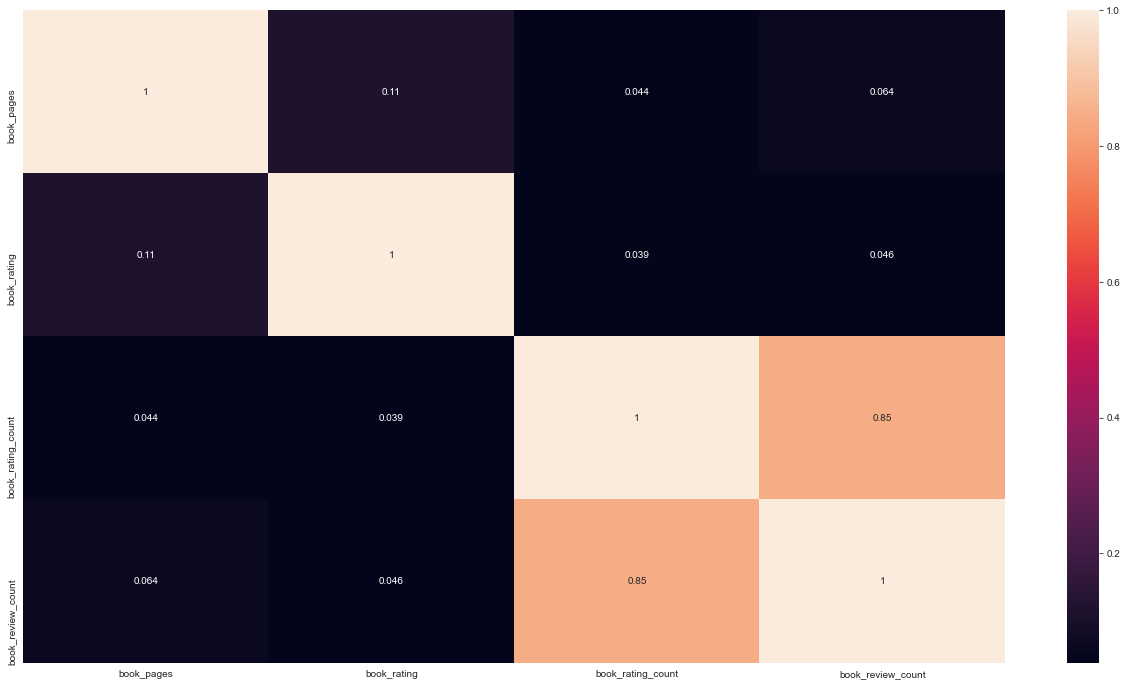

In [10]:
# Pintamos la matriz de correlación con el valor en cada celda y mapa de calor con un gradiente de color en 
# consecuencia
corr = df_books_final_num.corr()

plt.figure(figsize=(22, 12))
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)

(4, 5]    28656
(3, 4]    25312
(2, 3]      250
(1, 2]        6
(0, 1]        2
Name: book_rating, dtype: int64


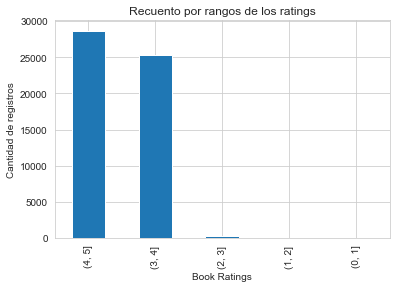

In [11]:
# mostramos por rango el recuento por rating de los libros. La mayoría de valoraciones son positivas.
rango = [0, 1, 2, 3, 4, 5]
grafico_segmentacion(df_books_final, 'book_rating', rango, 'Recuento por rangos de los ratings',\
                     'Book Ratings', 'Cantidad de registros')

(300, 500]      23703
(200, 300]      12932
(100, 200]       7480
(500, 1000]      5696
(0, 100]         3538
(1000, 5000]      746
Name: book_pages, dtype: int64


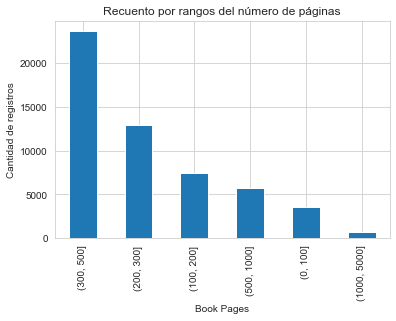

In [12]:
# ahora vemos por rangos la cantidad de reviews por número de páginas del libro en cuestión. El mayor número de
# libros en cuanto a rango de nº páginas sería entre las 300 y 500 páginas.
rango = [0, 100, 200, 300, 500, 1000, 5000]
grafico_segmentacion(df_books_final, 'book_pages', rango, 'Recuento por rangos del número de páginas',\
                     'Book Pages', 'Cantidad de registros')

In [13]:
# unificamos los títulos de libros en mayúsculas y quitando posibles espacios a los lados
df_books_final['book_title'] = df_books_final['book_title'].str.strip()
df_books_final['book_title'] = df_books_final['book_title'].str.upper()
print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_books_final.shape[0], df_books_final.shape[1]))

Dataset: num_rows: 54301	Columnas: 8



In [14]:
# eliminamos registros con el título duplicado
df_books_final.drop_duplicates('book_title', keep="first", inplace=True)
print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_books_final.shape[0], df_books_final.shape[1]))

Dataset: num_rows: 48294	Columnas: 8



In [15]:
# filtramos por ejemplo para ver los registros que son reviews de libros del autor Cormac McCarthy
df_books_mccarthy = df_books_final[df_books_final['book_authors'] == 'Cormac McCarthy']
print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_books_mccarthy.shape[0], df_books_mccarthy.shape[1]))

Dataset: num_rows: 13	Columnas: 8



In [16]:
# si ordenamos por mejor rating, vemos como la trilogía de la frontera sería el libro más valorado del autor
df_books_mccarthy.sort_values(by='book_rating', ascending=False)

,book_authors,book_format,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres
3691,Cormac McCarthy,Hardcover,1040,4.44,5089,300,"THE BORDER TRILOGY: ALL THE PRETTY HORSES, THE...",Fiction|Westerns|Literature|Novels|Literature|...
442,Cormac McCarthy,Paperback,337,4.18,89801,8171,"BLOOD MERIDIAN, OR THE EVENING REDNESS IN THE ...",Fiction|Westerns|Historical|Historical Fiction...
1413,Cormac McCarthy,Paperback,471,4.18,15371,1206,SUTTREE,Fiction|Gothic|Southern Gothic|Literature|Nove...
18666,Cormac McCarthy,Paperback,337,4.18,89855,8176,BLOOD MERIDIAN: OR THE EVENING REDNESS IN THE ...,Fiction|Westerns|Historical|Historical Fiction...
594,Cormac McCarthy,Paperback,309,4.13,121091,6870,NO COUNTRY FOR OLD MEN,Fiction|Thriller|Mystery|Crime|Westerns|Myster...
1838,Cormac McCarthy,Hardcover,426,4.12,26367,1695,THE CROSSING,Westerns|Fiction|Literature|Novels
4164,Cormac McCarthy,Paperback,292,4.08,17399,981,CITIES OF THE PLAIN,Fiction|Westerns|Literature|Novels
864,Cormac McCarthy,Paperback,302,3.98,81489,5287,ALL THE PRETTY HORSES,Fiction|Westerns|Historical|Historical Fiction...
78,Cormac McCarthy,Hardcover,241,3.96,612741,41379,THE ROAD,Fiction|Science Fiction|Science Fiction|Dystop...
11206,Cormac McCarthy,Paperback,160,3.96,7126,707,THE SUNSET LIMITED,Plays|Fiction|Drama|Philosophy


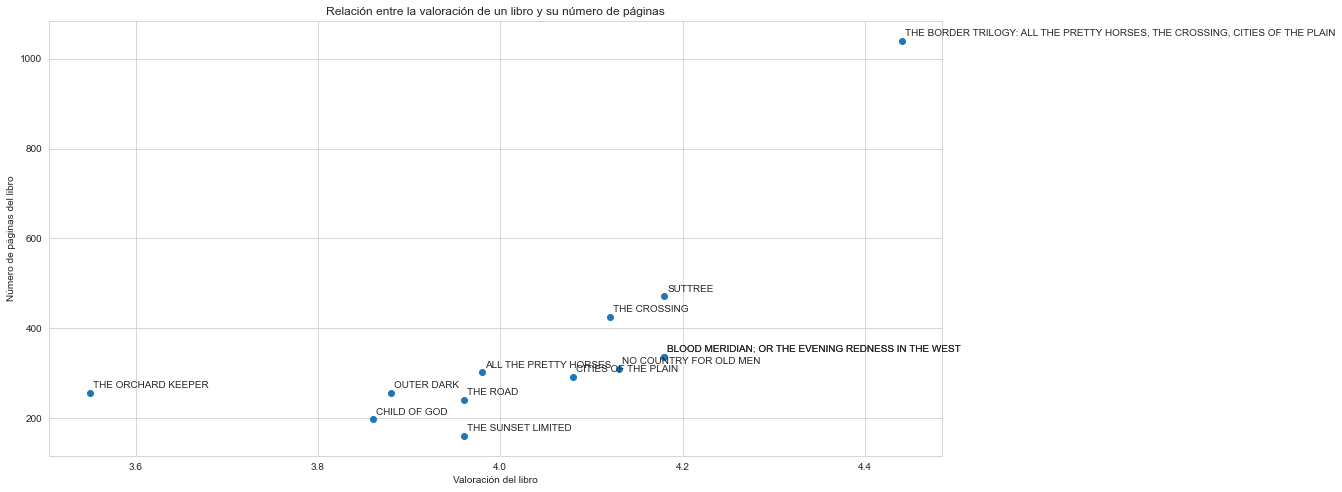

In [18]:
# graficamos los nombres de los libros del autor y su posición en relación a su valoración y su número de páginas
plt.figure(figsize=(16, 8))
plt.scatter(df_books_mccarthy.iloc[:]['book_rating'], df_books_mccarthy.iloc[:]['book_pages'])

for i in range(len(df_books_mccarthy)):
    xy_text = (3, 5)
    name = df_books_mccarthy.iloc[i]['book_title']
    plt.annotate(s= name, xy=(df_books_mccarthy.iloc[i]['book_rating'], df_books_mccarthy.iloc[i]['book_pages']),\
                 xycoords = "data", textcoords='offset points', xytext=xy_text)
    
plt.xlim()

plt.title("Relación entre la valoración de un libro y su número de páginas")
plt.ylabel("Número de páginas del libro")
plt.xlabel("Valoración del libro")

plt.show()

#### 2. Análisis del sentimiento

Para hacer el análisis de sentimiento de textos, utilizamos otros datos que como se dijo al inicio son los datos de reviews de la web de Booking de hoteles.
Estos datos tendrán los textos de dichas reviews, y una valoración, y en base al texto y su valoración (positiva o negativa) se pueden entrenar modelos y luego usarlos para predecir otros textos y ver si el modelo predice correctamente.

In [26]:
# carga de los datos de reviews de Booking
df_reviews = cargar_datos('Hotel_Reviews.csv')

Dataset: num_rows: 515738	Columnas: 17

columns:
 ['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags', 'days_since_review', 'lat', 'lng']


In [27]:
df_reviews.head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
5,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,Poland,Backyard of the hotel is total mess shouldn t...,17,1403,Good restaurant with modern design great chil...,20,1,6.7,"[' Leisure trip ', ' Group ', ' Duplex Double ...",10 days,52.360576,4.915968
6,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Cleaner did not change our sheet and duvet ev...,33,1403,The room is spacious and bright The hotel is ...,18,6,4.6,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",17 days,52.360576,4.915968
7,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Apart from the price for the brekfast Everyth...,11,1403,Good location Set in a lovely park friendly s...,19,1,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",17 days,52.360576,4.915968
8,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/9/2017,7.7,Hotel Arena,Belgium,Even though the pictures show very clean room...,34,1403,No Positive,0,3,6.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",25 days,52.360576,4.915968
9,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/8/2017,7.7,Hotel Arena,Norway,The aircondition makes so much noise and its ...,15,1403,The room was big enough and the bed is good T...,50,1,7.9,"[' Leisure trip ', ' Couple ', ' Large King Ro...",26 days,52.360576,4.915968


In [28]:
visualizar_datos(df_reviews)

Estadísticas esenciales de los datos:
                                               count         mean  \
Additional_Number_of_Scoring                515738.0   498.081836   
Average_Score                               515738.0     8.397487   
Review_Total_Negative_Word_Counts           515738.0    18.539450   
Total_Number_of_Reviews                     515738.0  2743.743944   
Review_Total_Positive_Word_Counts           515738.0    17.776458   
Total_Number_of_Reviews_Reviewer_Has_Given  515738.0     7.166001   
Reviewer_Score                              515738.0     8.395077   
lat                                         512470.0    49.442439   
lng                                         512470.0     2.823803   

                                                    std        min  \
Additional_Number_of_Scoring                 500.538467   1.000000   
Average_Score                                  0.548048   5.200000   
Review_Total_Negative_Word_Counts             29.690831   0.0

In [29]:
# preparar datos eliminando columnas que no necesitemos para el análisis de sentimiento, y a rellenar datos vacíos
# o nulos. 
# Para este tipo de análisis solo nos hace falta la columna del texto de la review, y la puntuación de dicha
# review. En este caso tenemos dos columnas con texto, una para los textos negativos y otro para los positivos.
columnas_eliminar = ['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date', 'Average_Score',\
        'Hotel_Name', 'Reviewer_Nationality', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',\
        'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Tags',\
        'days_since_review', 'lat', 'lng']
                     
df_reviews_final = preparar_df(df_reviews,1,columnas_eliminar,0)

print("Dataset: num_rows: %d\tColumnas: %d\n" % (df_reviews_final.shape[0], df_reviews_final.shape[1]))
print("columns:\n", list(df_reviews_final.columns))
print('\n')
print("Ver si hay datos nulos (False indica que ese atributo tiene registros vacíos o nulos):")
print(df_reviews_final.notnull().all())

Dataset: num_rows: 515738	Columnas: 3

columns:
 ['Negative_Review', 'Positive_Review', 'Reviewer_Score']


Ver si hay datos nulos (False indica que ese atributo tiene registros vacíos o nulos):
Negative_Review    True
Positive_Review    True
Reviewer_Score     True
dtype: bool


In [30]:
df_reviews_final.head()

,Negative_Review,Positive_Review,Reviewer_Score
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9
1,No Negative,No real complaints the hotel was great great ...,7.5
2,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1
3,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8
4,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7


In [31]:
# ahora el atributo del score de las reviews lo pasamos a valores 0 o 1 (para luego entrenar los modelos
# es necesario clasificar con estos valores las reviews): 0 para indicar review negativa
# que en este caso cogemos como idea las que sean notas menores a 6, y el 1 indicará una review positiva que 
# serán aquellas puntuadas con un 6 o mayor valor.
df_reviews_final["Reviewer_Score"] = df_reviews_final["Reviewer_Score"].apply(lambda x: 1 if x >= 6 else 0)

df_reviews_final.head(5)

,Negative_Review,Positive_Review,Reviewer_Score
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,0
1,No Negative,No real complaints the hotel was great great ...,1
2,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,1
3,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,0
4,You When I booked with your company on line y...,Amazing location and building Romantic setting,1


In [32]:
# como en este caso cada review tiene tanto un atributo con información negativa como otro con información
# positiva, lo que haremos será que si hemos clasificado una review como negativa porque su nota es inferior a un
# 6, pues nos quedaremos solo con el texto negativo, y al contrario en el caso de reviews positivas.
df_reviews_final_copy = df_reviews_final.copy()

condiciones = [(df_reviews_final_copy['Reviewer_Score'] == 0),
               (df_reviews_final_copy['Reviewer_Score'] == 1)]

elecciones = [df_reviews_final_copy['Negative_Review'], df_reviews_final_copy['Positive_Review']]
df_reviews_final_copy["review"] = np.select(condiciones, elecciones, -1)

df_reviews_final_copy = df_reviews_final_copy.drop(columns=['Negative_Review', 'Positive_Review'])

In [33]:
df_reviews_final_copy.head()

,Reviewer_Score,review
0,0,I am so angry that i made this post available...
1,1,No real complaints the hotel was great great ...
2,1,Location was good and staff were ok It is cut...
3,0,My room was dirty and I was afraid to walk ba...
4,1,Amazing location and building Romantic setting


In [34]:
# recuento por positivas/negativas (1/0)
print(pd.value_counts(df_reviews_final_copy["Reviewer_Score"]))

1    463231
0     52507
Name: Reviewer_Score, dtype: int64


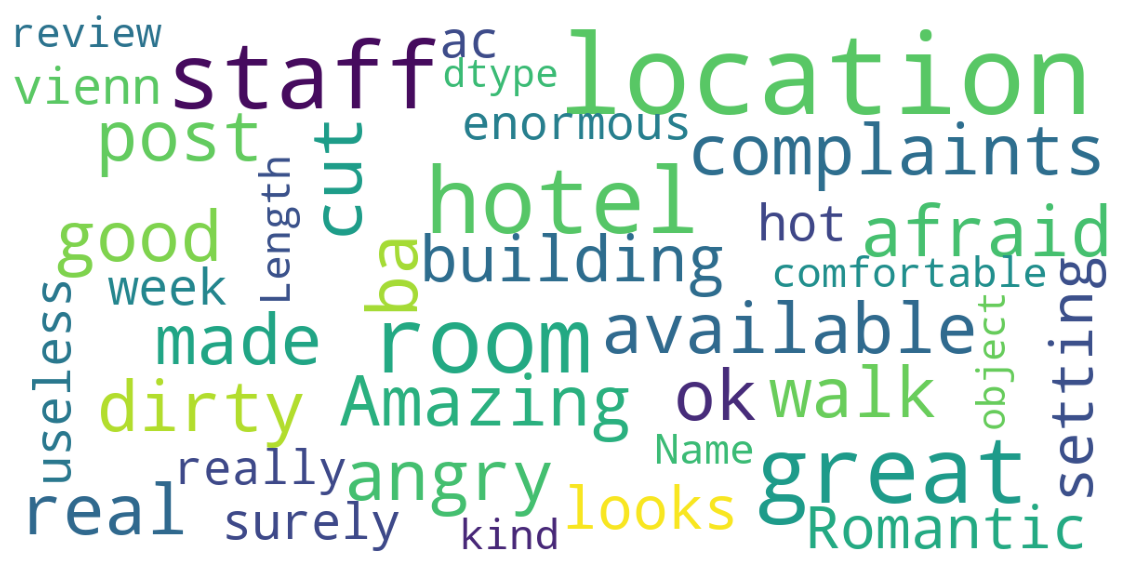

In [35]:
# Una forma de dar un vistazo a los datos, es usar wordcloud y pintar una nube de palabras en relación a su 
# importancia en los datos.

# cargamos las stopwords del módulo para datos en inglés
stopwords_english = set(STOPWORDS)

# pintamos el wordcloud en las reviews
show_wordcloud(df_reviews_final_copy["review"], stopwords_english)

#### 1. Una forma de analizar el sentimiento de forma rápida y sencilla es utilizar la librería TextBlob.

Esta libreria nos permite directamente con métodos que tiene, calcular el sentimiento de un texto sin tener que entrenar un modelo previo de machine learning.

In [36]:
# aplicamos las funciones a los textos del dataframe, primero hacemos una copia para conservar el original.
# aplicamos la función generada arriba para preprocesar y limpiar el texto, eliminando caracteres que no sean
# de valor para este análisis de texto.
df_clean = df_reviews_final_copy.copy()
df_clean['review'] = df_clean['review'].apply(limpiar_texto)

In [37]:
# damos un vistazo a los textos resultantes sobre los que aplicaremos textblob
print("\nDataframe limpio:\n", df_clean.tail(10))


Dataframe limpio:
         Reviewer_Score                                             review
515728               0                                         everything
515729               1   the breakfast was excelent lots of fress frui...
515730               1                                         large room
515731               1                                     good breakfast
515732               1   helpful staff allowed me to check in early as...
515733               1                                           location
515734               0             the hotel looks like  but surely not  
515735               0   the ac was useless it was a hot week in vienn...
515736               1   the rooms are enormous and really comfortable...
515737               1                               staff was very kind 


In [38]:
# funciones para aplicar textblob al conjunto de textos, y obtener para cada texto el valor de la polaridad.
# Para valores positivos asignamos el valor '1', y para valores negativos asignamos el valor '0'.
def analizar_sentimiento(texto):
    analysis = TextBlob(texto)
        
    if analysis.sentiment.polarity > 0:
        return 1
    else:
        return 0

In [39]:
# aplicar textblob a textos
df_clean['sentiment'] = df_clean['review'].apply(analizar_sentimiento)

In [40]:
print("Datos preprocesados: \n", df_clean.head(10))

Datos preprocesados: 
    Reviewer_Score                                             review  \
0               0   i am so angry that i made this post available...   
1               1   no real complaints the hotel was great great ...   
2               1   location was good and staff were ok it is cut...   
3               0   my room was dirty and i was afraid to walk ba...   
4               1    amazing location and building romantic setting    
5               1   good restaurant with modern design great chil...   
6               0   cleaner did not change our sheet and duvet ev...   
7               1   good location set in a lovely park friendly s...   
8               1                                        no positive   
9               1   the room was big enough and the bed is good t...   

   sentiment  
0          1  
1          1  
2          1  
3          0  
4          1  
5          1  
6          1  
7          1  
8          0  
9          1  


In [41]:
# ver resultados obtenidos
# vemos los distintos valores que tiene la columna del sentimiento en ambos datasets
print("Recuento valores datos originales:",pd.value_counts(df_reviews_final_copy['Reviewer_Score']))
print('\n')
print("Recuento valores datos procesados y calculado por Textblob:",pd.value_counts(df_clean['sentiment']))

Recuento valores datos originales: 1    463231
0     52507
Name: Reviewer_Score, dtype: int64


Recuento valores datos procesados y calculado por Textblob: 1    392487
0    123251
Name: sentiment, dtype: int64


#### 2. Uso de librería Spacy.

Con textblob anteriormente vimos como es una forma rápida y sencilla, porque se puede calcular el sentimiento del texto directamente. De todos modos, se aprecia con el uso como falla de forma bastante común, no es la mejor solución y sufre mucho el clasificador de Textblob cuando los textos son ambiguos, lo cual es lo más normal cuando hablamos de reviews en una aplicación de internet.

Ahora vemos como usar Spacy, para realizar un análisis morfosintáctico antes de entrenar los modelos.

In [42]:
# spaCy utiliza modelos morfosintácticos específicos para cada idioma. Por defecto la librería no incluye ningún 
# modelo, pero podemos instalarlo de manera sencilla con comandos a python. 
# La siguiente línea ejecuta un comando de sistema para instalar el modelo de spaCy para el idioma inglés.
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [43]:
# cargar modelo en memoria
nlp_eng = spacy.load('en')

In [44]:
# Ejemplo de uso de Spacy. Lo más interesante son los diferentes campos con información extra que 
# contiene cada token.
frase = "Phrase detected as an example of the use of Spacy library to analyze texts."
doc = nlp_eng(frase)

for token in doc:
    print("Token:", token)
    
pd.DataFrame(columns=["token", "lema", "POS", "tag", "shap", "isalpha", "isstop", "padre", "dep"],
    data=[[token.text, token.lemma_, token.pos_, token.tag_,
        token.shape_, token.is_alpha, token.is_stop, token.head, token.dep_]
        for token in doc]
)

Token: Phrase
Token: detected
Token: as
Token: an
Token: example
Token: of
Token: the
Token: use
Token: of
Token: Spacy
Token: library
Token: to
Token: analyze
Token: texts
Token: .


,token,lema,POS,tag,shap,isalpha,isstop,padre,dep
0,Phrase,phrase,NOUN,NN,Xxxxx,True,False,detected,nsubj
1,detected,detect,VERB,VBD,xxxx,True,False,detected,ROOT
2,as,as,ADP,IN,xx,True,True,detected,prep
3,an,an,DET,DT,xx,True,True,example,det
4,example,example,NOUN,NN,xxxx,True,False,as,pobj
5,of,of,ADP,IN,xx,True,True,example,prep
6,the,the,DET,DT,xxx,True,True,use,det
7,use,use,NOUN,NN,xxx,True,False,of,pobj
8,of,of,ADP,IN,xx,True,True,use,prep
9,Spacy,Spacy,PROPN,NNP,Xxxxx,True,False,library,compound


In [54]:
df_clean = df_reviews_final_copy.copy()
# usamos un sample de los datos ya que tiene un tamaño elevado y en local hay ciertas tareas de Spacy que pueden
# hacerse muy pesadas.
df_sample_english = df_clean.sample(frac=0.1, replace=False, random_state=1)

In [55]:
# reparto de valores del atributo sentimiento del sample generado de los datos en inglés
print("Valores dataset:\n",pd.value_counts(df_sample_english['Reviewer_Score']))

Valores dataset:
 1    46331
0     5243
Name: Reviewer_Score, dtype: int64


In [56]:
# utilizamos una función para ejecutar dicho análisis morfosintáctico a cada texto de los dataframes
# lo aplicamos al dataframe de datos
def add_analyzed(df):
    analyzed = [nlp_eng(text) for text in df["review"]]
    df["analyzed"] = pd.Series(analyzed, index = df.index)
    
add_analyzed(df_sample_english)
df_sample_english.head()

,Reviewer_Score,review,analyzed
356054,1,Nothing was too much trouble The staff were a...,"( , Nothing, was, too, much, trouble, The, sta..."
395957,1,I loved there shower It felt like you were un...,"( , I, loved, there, shower, It, felt, like, y..."
468352,1,beds really comfy and the location is great a...,"( , beds, really, comfy, and, the, location, i..."
281462,1,Really nice hotel good facilities great staff...,"( , Really, nice, hotel, good, facilities, gre..."
498978,1,Everything is super And room and design Very ...,"( , Everything, is, super, And, room, and, des..."


In [57]:
# utilizamos otra función para aplicar a los textos los filtrados y transformaciones comentados
# y acabamos obteniendo un texto limpio y quitándole formas verbales y otros elementos que puedan entorpecer el
# análisis del texto.
def add_posfilter(df):
    posfilter = [" ".join([token.lemma_ for token in text 
                           if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"} and not token.is_stop]) 
                 for text in df["analyzed"]]
    df["posfilter"] = pd.Series(posfilter, index = df.index)
    
add_posfilter(df_sample_english)
df_sample_english.head()

,Reviewer_Score,review,analyzed,posfilter
356054,1,Nothing was too much trouble The staff were a...,"( , Nothing, was, too, much, trouble, The, sta...",trouble staff attentive time hotel staff stay ...
395957,1,I loved there shower It felt like you were un...,"( , I, loved, there, shower, It, felt, like, y...",love shower feel fire hose great hotel
468352,1,beds really comfy and the location is great a...,"( , beds, really, comfy, and, the, location, i...",bed comfy location great maid sweetheart
281462,1,Really nice hotel good facilities great staff...,"( , Really, nice, hotel, good, facilities, gre...",nice hotel good facility great staff clean min...
498978,1,Everything is super And room and design Very ...,"( , Everything, is, super, And, room, and, des...",super room design clean


In [58]:
# rellenamos con espacios los datos vacíos por si hubiera alguno y pudiera dar problemas posteriormente
df_sample_english = df_sample_english.fillna(' ')

In [59]:
# reparto de datos entre datos de entrenamiento del modelo y datos de testeo del mismo
X_eng = df_sample_english['posfilter']
y_eng = df_sample_english['Reviewer_Score']

X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(X_eng, y_eng, test_size=0.1, random_state=42)

In [60]:
# montamos un modelo basado en el análisis de palabras. podría ser más simple con análisis por caracter, pero 
# es menos efectivo.
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
    ]
)

params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'vectorizer__analyzer' : ['word'],
    'vectorizer__ngram_range' : [(1, 1), (1,2), (1,3)]
}

# lo entrenamos y evaluamos con los datos en inglés
model = GridSearchCV(pipeline, params, n_jobs = 7)
model.fit(X_eng_train.values, y_eng_train)
model.score(X_eng_test.values, y_eng_test)

0.9687863512989531

In [61]:
# evaluamos resultados del modelo con la métrica roc_auc_score, que es más fiable para analizar la efectividad
# de un modelo.
y_pred = model.predict(X_eng_test)

roc_auc = roc_auc_score(y_eng_test, y_pred)

roc_auc

0.8724079327336263

#### 3. Utilizar modelo de entrenamiento de la librería Scikit-learn.

Vamos a probar un clasificador y dicho modelo para luego aplicarlo a datos nuevos.

Hay que tener en cuenta, que para hacer un modelo realmente efectivo, haría falta tener un dataset de datos mucho mayor, para que pueda entrenar más profundamente, y contar con la mejor máquina posible para poder realizar dichas tareas.
Además, en este caso se aprecian como los datos están desbalanceados, hay bastante diferencia entre reviews catalogadas como positivas y reviews catalogadas como negativas, por lo tanto cualquier modelo entrenado con dichos datos funcionará mejor para un tipo de sentimiento que para otro.

Por último, aunque añada algo de complejidad, es recomendable tener en cuenta una tercera clase para el sentimiento, que sería el neutro.

In [62]:
df_clean_sklearn = df_reviews_final_copy.copy()

In [63]:
# aplicamos las funciones de limpieza a los textos
df_clean_sklearn = limpiar_df(df_clean_sklearn)

In [64]:
df_clean_sklearn.head(10)

,Reviewer_Score,review
0,0,i am so angry that i made this post available...
1,1,no real complaints the hotel was great great ...
2,1,location was good and staff were ok it is cut...
3,0,my room was dirty and i was afraid to walk ba...
4,1,amazing location and building romantic setting
5,1,good restaurant with modern design great chil...
6,0,cleaner did not change our sheet and duvet ev...
7,1,good location set in a lovely park friendly s...
8,1,no positive
9,1,the room was big enough and the bed is good t...


In [68]:
# usamos un sample de los datos ya que tiene un tamaño elevado y en local hay ciertas tareas de Spacy que pueden
# hacerse muy pesadas.
df_sample_english = df_clean_sklearn.sample(frac=0.3, replace=False, random_state=1)

In [69]:
# reparto de datos entre train y test para entrenar y testear los modelos
X_eng_train, X_eng_test, y_eng_train, y_eng_test = split_df(df_sample_english)

In [70]:
# cargamos las stopwords que son aquellas palabras del lenguaje muy comunes y que no aportan nada para este caso,
# como por ejemplo los artículos.
english_stopwords = stopwords.words('english')

In [71]:
# modelo clasificador Naive Bayes. Usamos para generar el modelo y para evaluarlo las funciones definidas arriba.
clasificador = MultinomialNB()

model_eng_naive = generar_modelo(clasificador, english_stopwords, X_eng_train, y_eng_train)

In [72]:
# evaluamos los modelos
evaluar_modelos(model_eng_naive, X_eng_test, y_eng_test)

Mejores parámetros del modelo para datos en inglés: 
 {'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x172691048>>,
                vocabular

In [74]:
# generamos un Dataframe con 5 reviews para probar el modelo
review = ['This book is very good, I love it!!',\
               'I quite liked the book, despite its ending, which is regular.',\
               'I did not like anything, it is a very bad book.',\
               'This book sucks, it is horrible.',\
               'It is a great book!']

df_new = pd.DataFrame({'review': review})

In [75]:
# datos cargados iniciales
# limpiamos los textos
df_clean_new = limpiar_df(df_new)

In [76]:
# Predecimos usando el modelo de SVMs que ha obtenido los mejores resultados
y_pred_eng = model_eng_naive.predict(df_clean_new['review'])

In [77]:
# hacemos una copia de los dataframes con los textos limpios, y les añadimos la columna sentimiento con los valores
# que se han predecido con el modelo.
df_predict_english = df_clean_new.copy()

df_predict_english['sentiment'] = y_pred_eng

In [78]:
df_predict_english.head()

,review,sentiment
0,this book is very good i love it,1
1,i quite liked the book despite its ending wh...,1
2,i did not like anything it is a very bad book,0
3,this book sucks it is horrible,0
4,it is a great book,1


Como se puede apreciar, al aplicar el modelo con estos 5 textos creados, los cataloga de forma correcta.